In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, plot_confusion_matrix, hamming_loss
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import matplotlib.pyplot as plt
import spacy
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [3]:
def process_text(text, is_spacy=False, keep_stopwords=True):
    
    '''
    Processes, cleans, and tokenizes text with multiple options on how to do so. Returns either a SpaCy doc object or a list of tokens
    
    Parameters
    ----------
    text - (str) - the text to be processed
    is_spacy - (bool) - whether or not the return is a SpaCy doc with stop words included. If True is passed, keep_stopwords will be ignored
    keep_stopwords - (bool) - whether or not to remove stopwords using the nltk stopwords library
    keep_links - (bool) - whether or not to turn a handle and website link into a blank word such as WEBSITE for the purposes of sentence structure vectorization
    keep_hashtags - (bool) - whether or not to simply remove the # symbol from a hashtag or remove the hashtag completely
    
    Returns
    -------
    Processed text - doc, if OR list
    
    '''
    doc = nlp(text) # Turns the resulting string into a SpaCy doc object
    
    if is_spacy == True:
        return doc
    
    text = text.replace("'", '') # Removes apostrophes
    
    if keep_stopwords == False: # Makes all tokens lower case, removes punctuation and stopwords
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False and token.text.lower() not in stopwords_list])]
    else: # Does the same thing, but keeps stopwords in
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False])]

In [29]:
class TextSet:

    
    def __init__(self, X, y, name=None, is_spacy=False, multi_label=False, keep_stopwords=False, random_seed=42, split=.3):
        '''
        Constructs necessary attributes for the Model_Analysis object and automatically processes the X data into Holdout, 
        Train and Test sets ready for vectorization. Also proceses y into labels and sparse OHE matrices, split into Holdout, 
        Train, and Test sets. The Holdout set is 10% of the original test data.
        Parameters:
        ----------
        X : Series or Array
            The text that will be processed in a fashion determined by the other arguments. It will be split into holdout, train, and test batches for testing. 
        y : Series or Array
            The target values for the accompanying texts passed in X. Will be processed with both a label encoder and a one hot encoded sparse matrix. Must be the same dimensions as X.
        name : String
            The name of the TextSet. Used for labeling purposes during analysis.
        is_spacy : Boolean
            Whether or not the text will be processed into a SpaCy doc and will use the SpaCy vectorization method.
        keep_stopwords: Boolean
            Whether or not the processed text will include stop words
        keep_links: Boolean
            If True is passed, Twitter handles and Web URLs will be replaced with dummy words. If False, then the links will be removed completely
        keep_hashtags: Boolean
            If True is passed, the hashtag symbol will be removed, but the rest of the hashtag will remain. If False, then the entire hashtag will be removed.
        random_seed: int
            The random state used for partitioning data
        split: float
            The size of the test set when splitting data into train and test
        '''

        self.X = X
        self.y = y
        self.multi_label = multi_label
        self.name = name
        self.is_spacy = is_spacy
        self.keep_stopwords = keep_stopwords
        self.random_seed = random_seed
        self.split = split
        self.process_data()
            
    def process_data(self):
        '''
        Takes X and y and tokenizes the text based on the methods determined by the class's parameters. 
        The data is then split into a 10% holdout group, train, and test groups. The target y variable is 
        processed into labels and one hot encoded sparse matricies.
        
        Parameters
        ----------
        
        None
        
        Returns
        -------
        text : List
            A list of all processed tokens in the X column
        X_holdout_tokens : List
            Tokenized list of the X holdout group
        X_train_tokens : List
            Tokenized list of the X train group
        X_test_tokens : List
            Tokenized list of the X test group
        y_holdout_ohe : Array
            A sparse matrix of the y holdout group
        y_holdout_l : Array
            A 1D labeled array of the y train group
        y_train_ohe : Array
            A sparse matrix of the y train group
        y_train_l : Array
            A 1D labeled array of the y train group
        y_test_ohe : Array
            A sparse matrix of the y test group
        y_test_l : Array
            A 1D labeled array of the y test group
        y_ohe : OneHotEncoder
            The one hot encoder used to transform y values into sparse matricies
        y_labeler : LabelEncoder
            The label encoder used to transform the y values into the labels fo testing
        process_time 
        : int
            Amount of time in seconds for text to process
        '''
        start_time = time.time()
        
        self.tokens = [process_text(text, 
                                    is_spacy=self.is_spacy, 
                                    keep_stopwords=self.keep_stopwords) for text in self.X]
        
        
        X_processed, self.X_holdout_tokens, y_processed, self.y_holdout = train_test_split(self.tokens, 
                                                                              self.y, 
                                                                              random_state=self.random_seed, 
                                                                              test_size=.1)
        
        self.X_train_tokens, self.X_test_tokens, self.y_train, self.y_test = train_test_split(X_processed, 
                                                                              y_processed, 
                                                                              random_state=self.random_seed, 
                                                                              test_size=self.split)
        
        if self.is_spacy == True:
            token_list = []
            for doc in self.tokens:
                token_list.append([token.text for token in doc])
            self.tokens = token_list
            
        self.text = [' '.join(x) for x in self.tokens]
        
        if self.multi_label == False:
            encoder = OneHotEncoder()
            self.y_train_ohe = encoder.fit_transform(np.array(self.y_train).reshape(-1,1))
            self.y_test_ohe = encoder.transform(np.array(self.y_test).reshape(-1,1))
            self.y_holdout_ohe = encoder.transform(np.array(self.y_holdout).reshape(-1,1))
            self.y_ohe = encoder

            labeler = LabelEncoder()
            self.y_train_l = labeler.fit_transform(self.y_train)
            self.y_test_l = labeler.transform(self.y_test)
            self.y_holdout_l = labeler.transform(self.y_holdout)
            self.y_labeler = labeler

            self.y_train_ohe = self.y_train_ohe.toarray()
            self.y_test_ohe = self.y_test_ohe.toarray()
            self.y_holdout_ohe = self.y_holdout_ohe.toarray()
        else:
            pass
        
        self.process_time = time.time() - start_time
        
        print("--- %s seconds ---" % (self.process_time))
        
        
    def word_cloud(self):
        
        '''
        Visualizes the entire corpus of X into a frequency wordcloud
        
        Parameters
        ----------
        
        None
        
        Returns
        -------
        
        wordcloud : WordCloud
            A visualization of the wordcloud on a (6,6) graph
        '''

        words = ' '.join(self.text)

        self.wordcloud = WordCloud(width = 600, height = 600,
                        background_color ='white',
                        min_font_size = 10).generate(words)

        # plot the WordCloud image                       
        plt.figure(figsize = (6, 6), facecolor = None)
        plt.imshow(self.wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.title(f'Word Cloud For {self.name}')
        plt.show()
        
    
    def plot_frequency(self, num_words = 50):
        
        '''
        Creates a bar graph of the frequencies of each token in the complete corpus of X
        
        Parameters
        ----------
        
        num_words : int
            Number of words to be displayed
            
        Returns
        -------
        
        Bar Plot : graph
            A bar plot of the most frequent words in the X corpus
        '''
    
        data_concat = []

        for tweet in self.tokens:
            data_concat += tweet

        data_freqdist = FreqDist(data_concat)

        x = []
        y = []

        for token in data_freqdist.most_common(num_words):
            x.append(token[0])
            y.append(token[1])

        plt.figure(figsize=(15, 6))
        plt.bar(x=x, height=y)
        plt.xticks(rotation=45)
        plt.xlabel('Words')
        plt.title(f'{self.name} {num_words} Most Common Words')
        plt.ylabel('Frequency')
        plt.show()
    
    def vectorize(self, method='tf_idf', max_features=300, ngram_range=(1,1)):
        
        '''
        Turns X_train, X_test, and X_holdout into vectors for processing 
        
        Parameters
        ----------
        
        method : String - 'tf_idf' or 'count'
            Method of vectorization if is_spacy is False
        max_features : int
            Number of words to be included in the count or TF-IDF vectorization
        ngram_range : tuple
            Number of words to be considered as paired for tokenization
        
        Returns
        -------
        
        X_train: Array
            A vector representation of X_train tokens
        X_test: Array
            A vector representation of X_test tokens
        X_holdout: Array
            A vector representation of X_holdout tokens
        vectorizer: CountVectorizer or TfidfVectorizer
            The vectorizer used to transform the X data
        
        '''
        
        if self.is_spacy == True:
            self.X_train = np.array([doc.vector for doc in self.X_train_tokens])
            self.X_test = np.array([doc.vector for doc in self.X_test_tokens])
            self.X_holdout = np.array([doc.vector for doc in self.X_holdout_tokens])
        
        else:
            X_train = [' '.join(x) for x in self.X_train_tokens]
            X_test = [' '.join(x) for x in self.X_test_tokens]
            X_holdout = [' '.join(x) for x in self.X_holdout_tokens]
            
            if method == 'tf_idf':
                self.vectorizor = TfidfVectorizer(max_features=max_features,ngram_range=ngram_range)
                self.X_train = self.vectorizor.fit_transform(X_train)
                self.X_test = self.vectorizor.transform(X_test)
                self.X_holdout = self.vectorizor.transform(X_holdout)
                self.X_train = self.X_train.toarray()
                self.X_test = self.X_test.toarray()
                self.X_holdout = self.X_holdout.toarray()

            elif method == 'count':
                self.vectorizor = CountVectorizer(max_features=max_features, ngram_range=(1,1))
                self.X_train = self.vectorizor.fit_transform(X_train)
                self.X_test = self.vectorizor.transform(X_test)
                self.X_holdout = self.vectorizor.transform(X_holdout)
                self.X_train = self.X_train.toarray()
                self.X_test = self.X_test.toarray()
                self.X_holdout = self.X_holdout.toarray()
                
        
    def regularize(self):
        
        '''
        Normalizes the X vectors using a StandardScaler. Ideal for usage with neural networks. Must be run after the vectorize function.
        
        Parameters
        ----------
        
        None
        
        Returns
        -------
        
        scaler: StandardScaler
            The scaler used to transform X vectors
        X_train_scaled: Array
            The scaled vector of X_train
        X_test_scaled: Array
            The scaled vector of X_test
        X_holdout_scaled: Array
            The scaled vector of X_holdout
        '''
            
        self.scaler = StandardScaler()
            
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        self.X_holdout_scaled = self.scaler.transform(self.X_holdout)

In [4]:
class ModelComparison:
    
    def __init__(self, pipeline, data_list, y_format='label', nn=False, name=None):
            '''
            Constructs necessary attributes for the ModelComparison object. If nn is True then y_format will be changed to 'ohe'.
            Parameters:
            ----------
            pipeline : Classifier
                An untrained classification alogorithm for comparing against data. A pipeline is recommended in order to control scaling and imputing, but a regular model can be passed.
            data_list : List
                A list of TextSet objects with X, y train, test and holdout sets already processed and vectorized
            y_format : 'label', 'ohe' or 'multi_label'
                The format of the y_data. If 'label' is passed, then y_train_l will be used. If 'ohe', then y_train_ohe will be used. Else, y_train tokens will be used.
            nn : Boolean
                Whether or not the pipeline is a neural network
            name : String
                The name of the ModelComparison Object.
            '''
            self.pipeline = pipeline
            self.data_list = data_list
            self.name = name
            self.y_format = y_format
            self.data_names = {j:i for (i, j) in tuple(enumerate([x.name for x in self.data_list]))}
            self.ref_dict = {dataset.name : dataset for dataset in self.data_list}
            self.nn = nn
            
            if self.nn == True:
                self.y_format = 'ohe'
    
    def set_model(self, new_model, y_change=None, nn_change=False):
        '''
        Changes the model used for comparison.
        
        Parameters
        ----------
        
        new_model : Classifier
            An untrained classification alogorithm for comparing against data.
        y_change : 'label', 'ohe', 'raw' or None
            The new configuration of the y variable
        nn_change : Boolean
            Pass True if the new model is a neural network, else pass False
        
        '''
        self.pipeline = new_model
        if y_change != None:
            self.y_format = y_change
        
        if nn_change == True:
            self.nn = nn_change

    def fit_models(self, data=None, batch_size=15, epochs=20):
        
        '''
        Fits the model to each of the datasets and produces data for comparison and visualization.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        batch_size : int
            Size of batches used when training a Neural Network model. Ignored if nn is False.
        epochs : int
            Number of epochs used to train a Neural Network model. Ignored if nn is False.
            
        Returns
        -------
        
        data_dict : dictionary
            A dictionary with keys corresponding to the names of each dataset fit to the model. Contains all predicted y values for each dataset for visualization and comparison.
        score_comparison: dataframe
            A dataframe of scores for each dataframe with the maximum value in each row highlighted
        process_time: int
            Amount of time taken to fit the model to all datasets.
        '''
        
        start_time = time.time()
        self.data_dict = {}
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            if self.y_format == 'multi_label':
                y_dict_train = {'multi_label': dataset.y_train}
                y_dict_test = {'multi_label': dataset.y_test}
                y_dict_holdout = {'multi_label': dataset.y_holdout}
            
            else:
                y_dict_train = {
                    'label': dataset.y_train_l,
                    'ohe': dataset.y_train_ohe,
                    'raw': dataset.y_train
                    }

                y_dict_test = {
                    'label': dataset.y_test_l,
                    'ohe': dataset.y_test_ohe,
                    'raw': dataset.y_test
                }

                y_dict_holdout = {
                    'label': dataset.y_holdout_l,
                    'ohe': dataset.y_holdout_ohe,
                    'raw': dataset.y_holdout
                }
            
            y_train = y_dict_train[self.y_format]
            y_test = y_dict_test[self.y_format]
            y_holdout = y_dict_holdout[self.y_format]
            
            if self.nn == True:
                
                model = self.pipeline.fit(dataset.X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(dataset.X_train_scaled, y_train))
                
                y_train_preds = self.pipeline.predict(dataset.X_train_scaled)
                y_test_preds = self.pipeline.predict(dataset.X_test_scaled)
                y_holdout_preds = self.pipeline.predict(dataset.X_holdout_scaled)
                
                hold_val = self.pipeline.evaluate(dataset.X_holdout_scaled, y_holdout)
            
            else:
                model = self.pipeline.fit(dataset.X_train, y_train)
                
                y_train_preds = model.predict(dataset.X_train)
                y_test_preds = model.predict(dataset.X_test)
                y_holdout_preds = model.predict(dataset.X_holdout)
            
            if self.nn==False:
                
                self.data_dict[dataset.name] = {
                    'y_train': y_train,
                    'y_test': y_test,
                    'y_holdout': y_holdout,
                    'y_train_preds': y_train_preds, 
                    'y_test_preds': y_test_preds,
                    'y_holdout_preds': y_holdout_preds,   
                }
            
            else:
                self.data_dict[dataset.name] = {
                    'y_train': y_train,
                    'y_test': y_test,
                    'y_holdout': y_holdout,
                    'y_train_preds': y_train_preds, 
                    'y_test_preds': y_test_preds,
                    'y_holdout_preds': y_holdout_preds,
                    'model_history': model.history,
                    'holdout_history': hold_val
                }
        
        if self.nn == False:
            self.calc_scores(data=set_list)
        else:
            self.calc_nn_scores(data=set_list)
        self.process_time = time.time() - start_time
        print("--- %s seconds to process ---" % (self.process_time))
    
    def calc_scores(self, data=None, data_type='test'):
        
        '''
        Calculates all major scores on each dataset for comparison for non neural network datasets. Will return an error if the model is a neural network.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        data_type : String - 'test' or 'holdout'
            Determines the values compared in the final score comparison. If 'test', then the test scores will be compared. If 'holdout', then holdout scores will be shown.
        
        Returns
        -------
        
        all_scores : DataFrame
            All train and test scores for all datasets in a single dataframe showing scores for Accuracy, Precision, Recall and F1 Score. All values are calculated using the Macro method.
        score_comparison : DataFrame
            Test scores for each dataset compared in a single dataframe with the top value in each row highlighted.
        '''
        
        df_list = []
        
        title = data_type.title()
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            y_train = self.data_dict[dataset.name]['y_train']
            y_train_preds = self.data_dict[dataset.name]['y_train_preds']
        
            if data_type == 'test':
                
                y_val = self.data_dict[dataset.name]['y_test']
                y_val_preds = self.data_dict[dataset.name]['y_test_preds']
            
            elif data_type == 'holdout':
            
                y_val = self.data_dict[dataset.name]['y_holdout']
                y_val_preds = self.data_dict[dataset.name]['y_holdout_preds']
            
            if self.y_format != 'multi_label':
                dictionary = {
                    'Accuracy': [accuracy_score(y_train, y_train_preds), accuracy_score(y_val, y_val_preds)],
                    'Precision (Macro)': [precision_score(y_train, y_train_preds, average='macro'), precision_score(y_val, y_val_preds, average='macro')],
                    'Recall (Macro)': [recall_score(y_train, y_train_preds, average='macro'), recall_score(y_val, y_val_preds, average='macro')],
                    'F1 (Macro)': [f1_score(y_train, y_train_preds, average='macro'), f1_score(y_val, y_val_preds, average='macro')],
                }
            else:
                dictionary = {
                    'Accuracy': [accuracy_score(y_train, y_train_preds), accuracy_score(y_val, y_val_preds)],
                    'Precision (Macro)': [precision_score(y_train, y_train_preds, average='macro'), precision_score(y_val, y_val_preds, average='macro')],
                    'Precision (Micro)': [precision_score(y_train, y_train_preds, average='micro'), precision_score(y_val, y_val_preds, average='micro')],
                    'Recall (Macro)': [recall_score(y_train, y_train_preds, average='macro'), recall_score(y_val, y_val_preds, average='macro')],
                    'Recall (Micro)': [recall_score(y_train, y_train_preds, average='micro'), recall_score(y_val, y_val_preds, average='micro')],
                    'F1 (Micro)': [f1_score(y_train, y_train_preds, average='micro'), f1_score(y_val, y_val_preds, average='micro')],
                    'F1 (Macro)': [f1_score(y_train, y_train_preds, average='macro'), f1_score(y_val, y_val_preds, average='macro')],
                    'F1 (Samples)': [f1_score(y_train, y_train_preds, average='samples'), f1_score(y_val, y_val_preds, average='samples')],
                    'Hamming-Loss': [hamming_score(y_train, y_train_preds), hamming_score(y_val, y_val_preds)],
                }
            
            df = pd.DataFrame.from_dict(dictionary, orient='index', columns=[f'{dataset.name} Train',f'{dataset.name} {title}'])
            
            self.data_dict[dataset.name][f'{data_type} scores'] = df
            df_list.append(df)
        
        self.all_scores = pd.concat(df_list, axis=1)
        
        self.score_comparison = self.all_scores[[x for x in self.all_scores.columns if x.endswith(title)]]
        
        self.score_comparison = self.score_comparison.style.highlight_max(color='lightgreen', axis=1)
        
    def calc_nn_scores(self, data=None):
        
        '''
        Calculates accuracy and loss scores for each dataset if the model is a neural network. Will produce an error if the model is not a neural network.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        
        Returns
        -------
        
        score_comparison : DataFrame
            A dataframe comparing the accuracy and loss scores on the holdout data for each dataset
        '''

        df_list = []
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data

        for dataset in set_list:

            hist = self.data_dict[dataset.name]['holdout_history']

            dictionary = {
                'Loss': hist[0],
                'Accuracy': hist[1]
            }

            df = pd.DataFrame.from_dict(dictionary, orient='index', columns=[f'{dataset.name} Holdout'])

            df_list.append(df)

        self.score_comparison = pd.concat(df_list, axis=1)
            
    def compare_confusion(self, data_type='test', data=None):
        
        '''
        Plots a confusion matrix for either the Test or Holdout data for each dataset. Bear in mind, it will fit the model with all of the datsets again.
        
        Parameters
        ----------
        
        data_type : String - 'test' or 'holdout'
            Determines which dataset will be used in the confusion matrix
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
            
        Returns
        -------
        
        A confusion matrix for each dataset passed in data
        '''
        
        title = data_type.title()
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            X_train = dataset.X_train
            y_train = self.data_dict[dataset.name]['y_train']
            
            self.pipeline.fit(X_train, y_train)
            
            if data_type == 'train':
                X_val = dataset.X_train
                y_val = self.data_dict[dataset.name]['y_train']
            
            elif data_type == 'test':
                X_val = dataset.X_test
                y_val = self.data_dict[dataset.name]['y_test']
                
            elif data_type == 'holdout':
                X_val = dataset.X_holdout
                y_val = self.data_dict[dataset.name]['y_holdout']
        
            plot_confusion_matrix(self.pipeline, X_val, y_val, cmap=plt.cm.Blues)
            plt.title(f'{dataset.name} {title}')
            plt.show()
        
    def plot_roc_curve(self, data_type='test', include_train=True, data=None):
        
        '''
        Plots the ROC curve for the results of the model. If a multi-class model it will return an error
        
        Parameters
        ----------
        
        data_type : String - 'test' or 'holdout'
            Determines which dataset will be used in the ROC Plot
        include_train : Boolean
            If True is passed, the ROC plot will include the training data and the validation data
        data : List
            A list of processed TextSet objects. If None is passed, then all datasets will be included in the final plot.
        
        Returns
        -------
        
        A plot of the ROC curve of the train and validation data
        '''
        
        plt.figure(figsize=(7,7))
        ax = plt.gca()
        
        if data == None:
            set_list = self.data_list
        else:
            set_list = [self.ref_dict[name] for name in data]
        
        for dataset in set_list:
            if data_type == 'test':
                y_val = self.data_dict[dataset.name]['y_test']
                y_val_preds = self.data_dict[dataset.name]['y_test_preds']
            elif data_type == 'holdout':
                y_val = self.data_dict[dataset.name]['y_holdout']
                y_val_preds = self.data_dict[dataset.name]['y_holdout_preds']
            
            fpr, tpr, threshold = roc_curve(y_val, y_val_preds)
            plt.plot(fpr, tpr, label=f'{dataset.name} {data_type}', ax=ax)
            
            if include_train == True:
                y_train = self.data_dict[dataset.name]['y_train']
                y_train_preds = self.data_dict[dataset.name]['y_train_preds']
                
                fpr, tpr, threshold = roc_curve(y_train, y_train_preds)
                plt.plot(fpr, tpr, label=f'{dataset.name} train', ax=ax)
                
                
        plt.title(f'ROC Curve for {data_type} data')
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        
    def plot_val_history(self, data=None):
        
        '''
        Plots the accuracy and loss curves for both the training and the testing data for a neural network model.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then all datasets will be included in the final plots.
        
        Returns
        -------
        
        A subplot of the training and validation loss and accuracy values from the fit Neural Network model
        
        '''
        
        if data == None:
            set_list = self.data_list
        else:
            set_list = [self.ref_dict[name] for name in data]
        
        for dataset in set_list:
            history = self.data_dict[dataset.name]['model_history']
            fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12, 4))
            ax1.plot(history['val_loss'])
            ax1.plot(history['loss'])
            ax1.legend(['val_loss', 'loss'])
            ax1.set_title(f'{dataset.name} Loss')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')

            ax2.plot(history['val_acc'])
            ax2.plot(history['acc'])
            ax2.legend(['val_acc', 'acc'])
            ax2.set_title(f'{dataset.name} Accuracy')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Accuracy')
            plt.show()

In [5]:
def match_fields(df_1_column, df_2_column, reverse=False, verbose=True):
    
    '''
    Matches values in fields from two dataframes and returns lists of the missing and matched values.
    
    Parameters
    ----------
    df_1_column - dataframe column - one of the dataframes used for comparison
    df_2_column - dataframe column - the other dataframe used for comparison
    reverse - bool - reverses the matching. Defaults to false so all values in df_1 will be tested to see if they are in df_2. If true, will reverse that logic.
    
    Returns
    -------
    missing - list - all values missing from the two dataframes
    matched - list - all values found in both dataframe columns

    Examples:
    ---------

    matched, missing = ut.match_fields(df['Column'], df_2['Column'], reverse=False)
    '''
    
    if reverse == False:
    
        names = df_1_column.unique()
        accounts = df_2_column.unique()
    
    else:
        
        names = df_2_column.unique()
        accounts = df_1_column.unique()

    missing = []
    matched = []

    for n in names:
        if n in accounts:
            matched.append(n)
        else:
            missing.append(n)

    if verbose == True:
        print('Matched: ', len(matched))
        print('Missing: ', len(missing))

    return matched, missing

In [6]:
df_aliens = pd.read_csv('data/sf_aliens.csv')

In [7]:
df_alt = pd.read_csv('data/sf_alternate_history.csv')
df_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1249 non-null   object 
 1   Original_Book_Title  1249 non-null   object 
 2   Author_Name          1249 non-null   object 
 3   Edition_Language     1248 non-null   object 
 4   Rating_score         1249 non-null   float64
 5   Rating_votes         1249 non-null   int64  
 6   Review_number        1249 non-null   int64  
 7   Book_Description     1248 non-null   object 
 8   Year_published       1249 non-null   int64  
 9   Genres               1249 non-null   object 
 10  url                  1249 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [8]:
df_alt_u = pd.read_csv('data/sf_alternate_universe.csv')
df_alt_u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1247 non-null   object 
 1   Original_Book_Title  1247 non-null   object 
 2   Author_Name          1247 non-null   object 
 3   Edition_Language     1246 non-null   object 
 4   Rating_score         1247 non-null   float64
 5   Rating_votes         1247 non-null   int64  
 6   Review_number        1247 non-null   int64  
 7   Book_Description     1247 non-null   object 
 8   Year_published       1247 non-null   int64  
 9   Genres               1247 non-null   object 
 10  url                  1247 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.3+ KB


In [9]:
df_app = pd.read_csv('data/sf_apocalyptic.csv')
df_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1248 non-null   object 
 1   Original_Book_Title  1248 non-null   object 
 2   Author_Name          1248 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1248 non-null   float64
 5   Rating_votes         1248 non-null   int64  
 6   Review_number        1248 non-null   int64  
 7   Book_Description     1244 non-null   object 
 8   Year_published       1248 non-null   int64  
 9   Genres               1248 non-null   object 
 10  url                  1248 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.4+ KB


In [10]:
df_cyber = pd.read_csv('data/sf_cyberpunk.csv')
df_cyber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1244 non-null   object 
 1   Original_Book_Title  1244 non-null   object 
 2   Author_Name          1244 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1244 non-null   float64
 5   Rating_votes         1244 non-null   int64  
 6   Review_number        1244 non-null   int64  
 7   Book_Description     1226 non-null   object 
 8   Year_published       1244 non-null   int64  
 9   Genres               1244 non-null   object 
 10  url                  1244 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.0+ KB


In [11]:
df_dys = pd.read_csv('data/sf_dystopia.csv')
df_dys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1242 non-null   object 
 1   Original_Book_Title  1242 non-null   object 
 2   Author_Name          1242 non-null   object 
 3   Edition_Language     1241 non-null   object 
 4   Rating_score         1242 non-null   float64
 5   Rating_votes         1242 non-null   int64  
 6   Review_number        1242 non-null   int64  
 7   Book_Description     1241 non-null   object 
 8   Year_published       1242 non-null   int64  
 9   Genres               1242 non-null   object 
 10  url                  1242 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 106.9+ KB


In [12]:
df_hard = pd.read_csv('data/sf_hard.csv')
df_hard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1246 non-null   object 
 1   Original_Book_Title  1246 non-null   object 
 2   Author_Name          1246 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1246 non-null   float64
 5   Rating_votes         1246 non-null   int64  
 6   Review_number        1246 non-null   int64  
 7   Book_Description     1219 non-null   object 
 8   Year_published       1246 non-null   int64  
 9   Genres               1246 non-null   object 
 10  url                  1246 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.2+ KB


In [13]:
df_mil = pd.read_csv('data/sf_military.csv')
df_mil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1241 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1249 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [14]:
df_rob = pd.read_csv('data/sf_robots.csv')
df_rob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1247 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1239 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [15]:
df_space = pd.read_csv('data/sf_space_opera.csv')
df_space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1247 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1248 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [16]:
df_steam = pd.read_csv('data/sf_steampunk.csv')
df_steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1249 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1246 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [17]:
df_time = pd.read_csv('data/sf_time_travel.csv')
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1248 non-null   object 
 1   Original_Book_Title  1248 non-null   object 
 2   Author_Name          1248 non-null   object 
 3   Edition_Language     1244 non-null   object 
 4   Rating_score         1248 non-null   float64
 5   Rating_votes         1248 non-null   int64  
 6   Review_number        1248 non-null   int64  
 7   Book_Description     1247 non-null   object 
 8   Year_published       1248 non-null   int64  
 9   Genres               1248 non-null   object 
 10  url                  1248 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.4+ KB


In [18]:
df_aliens.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Obsidian,Obsidian,Jennifer L. Armentrout,English,4.17,236780,18161,Starting over sucks.When we moved to West Virg...,2011,"{'Young Adult': 3439, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/12578077-o...
1,Onyx,Onyx,Jennifer L. Armentrout,English,4.27,153429,10497,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,2012,"{'Young Adult': 2271, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13047090-onyx
2,The 5th Wave,The 5th Wave,Rick Yancey,English,4.03,400600,29990,"After the 1st wave, only darkness remains. Aft...",2013,"{'Young Adult': 5436, 'Science Fiction': 3327,...",https://www.goodreads.com/book/show/16101128-t...
3,The Host,The Host,Stephenie Meyer,English,3.84,915026,41673,Melanie Stryder refuses to fade away. The eart...,2008,"{'Young Adult': 4529, 'Science Fiction': 4285,...",https://www.goodreads.com/book/show/1656001.Th...
4,Opal,Opal,Jennifer L. Armentrout,None,4.27,129006,9463,No one is like Daemon Black.When he set out to...,2012,"{'Young Adult': 1855, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13362536-opal


In [19]:
genre_list = [
    'aliens',
    'alternate_history',
    'alternate_universe',
    'apocalyptic',
    'cyberpunk',
    'dystopia',
    'hard',
    'military',
    'robots',
    'space_opera',
    'steampunk',
    'time_travel'
]

df_list = []

for genre in genre_list:
    df = pd.read_csv(f'data/sf_{genre}.csv')
    df.drop_duplicates(subset=['Book_Title','Author_Name'],inplace=True)
    df[f'{genre}'] = 1
    df_list.append(df)

df_books = pd.concat(df_list)

In [20]:
genre_score = df_books[['Book_Title','Author_Name'] + [genre for genre in genre_list]].groupby(['Book_Title','Author_Name']).sum()

In [21]:
df_books = df_books.drop(columns=[genre for genre in genre_list]).drop_duplicates(subset=['Book_Title','Author_Name'])

In [22]:
df_desc = df_books.merge(genre_score, how='inner', on=['Book_Title','Author_Name'])

In [23]:
df_desc = df_desc.dropna(subset=['Book_Description'])

In [24]:
df_desc.describe()

,Rating_score,Rating_votes,Review_number,Year_published,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel
count,11025.000000,1.102500e+04,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000
mean,3.923708,2.529002e+04,1355.155193,2001.996825,0.113197,0.113107,0.113107,0.112834,0.111111,0.112562,0.110385,0.113288,0.112200,0.111837,0.113016,0.113016
std,0.296662,1.684630e+05,5403.296914,100.414819,0.316848,0.316737,0.316737,0.316405,0.314284,0.316071,0.313384,0.316959,0.315626,0.315180,0.316627,0.316627
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.730000,6.620000e+02,55.000000,2004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.930000,2.037000e+03,163.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.130000,7.387000e+03,597.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,7.336299e+06,174079.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11025 entries, 0 to 11094
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           11025 non-null  object 
 1   Original_Book_Title  11025 non-null  object 
 2   Author_Name          11025 non-null  object 
 3   Edition_Language     11000 non-null  object 
 4   Rating_score         11025 non-null  float64
 5   Rating_votes         11025 non-null  int64  
 6   Review_number        11025 non-null  int64  
 7   Book_Description     11025 non-null  object 
 8   Year_published       11025 non-null  int64  
 9   Genres               11025 non-null  object 
 10  url                  11025 non-null  object 
 11  aliens               11025 non-null  float64
 12  alternate_history    11025 non-null  float64
 13  alternate_universe   11025 non-null  float64
 14  apocalyptic          11025 non-null  float64
 15  cyberpunk            11025 non-null 

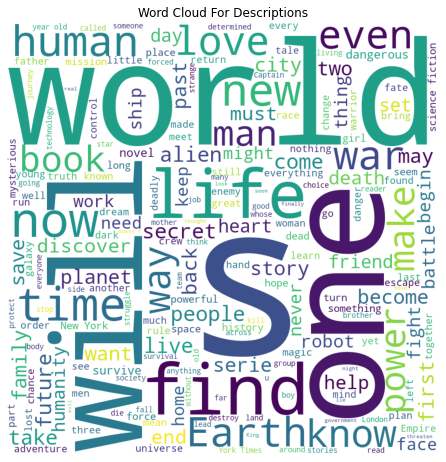

In [26]:
words = ' '.join(list(df_desc['Book_Description']))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

# plot the WordCloud image                       
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title(f'Word Cloud For Descriptions')
plt.show()

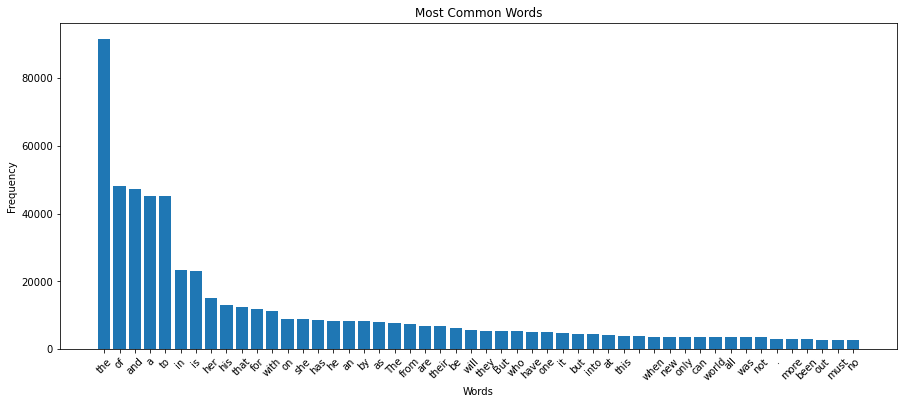

In [27]:
words = ' '.join(list(df_desc['Book_Description']))
tokens = words.split(' ')

data_freqdist = FreqDist(tokens)

x = []
y = []

for token in data_freqdist.most_common(50):
    x.append(token[0])
    y.append(token[1])

plt.figure(figsize=(15, 6))
plt.bar(x=x, height=y)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.title(f'Most Common Words')
plt.ylabel('Frequency')
plt.show()

In [35]:
stopwords_list = stopwords.words('english') + [' ', '  ', '   ', 'w/', 's', "'s", "n't",'’s','n’t','','-','.']

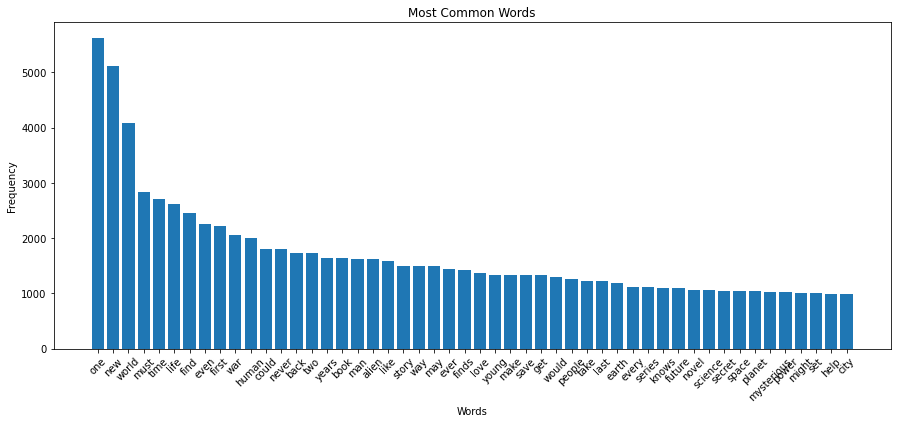

In [36]:
clean_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_list]

data_freqdist = FreqDist(clean_tokens)

x = []
y = []

for token in data_freqdist.most_common(50):
    x.append(token[0])
    y.append(token[1])

plt.figure(figsize=(15, 6))
plt.bar(x=x, height=y)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.title(f'Most Common Words')
plt.ylabel('Frequency')
plt.show()

In [40]:
df_desc['Review_number'].describe()

count     11025.000000
mean       1355.155193
std        5403.296914
min           0.000000
25%          55.000000
50%         163.000000
75%         597.000000
max      174079.000000
Name: Review_number, dtype: float64

In [41]:
df_desc['Rating_votes'].describe()

count    1.102500e+04
mean     2.529002e+04
std      1.684630e+05
min      0.000000e+00
25%      6.620000e+02
50%      2.037000e+03
75%      7.387000e+03
max      7.336299e+06
Name: Rating_votes, dtype: float64

In [42]:
df_pop = df_desc[df_desc['Review_number'] >= 55]

In [45]:
test_df = df_pop.sample(n=15)
str(test_df['Book_Description'])

'2448    His father and uncles are enchanters, his moth...\n4730    Alan is a middle-aged entrepreneur in contempo...\n3900    To live through the zombie apocalypse they hav...\n215     "I hate you." Please touch me. "You sicken me....\n4236    Nick Cole sends us on a suspenseful odyssey in...\n4173    Molecular biologist Kaye Lang\'s theory--that a...\n206     The rollicking sequel to Fortune\'s Pawn -- an ...\n4804    Making a living is hard. In a lawless city whe...\n1993    A postapocalyptic landscape of medieval and my...\n6972    Tanner Malone is starting to enjoy his navy po...\n3880    WHAT IF THE WORLD AS WE KNOW IT ENDED TOMORROW...\n3174    One unicorn dwells on Earth.Hundreds fight in ...\n1688    In a time when Shadowhunters are barely winnin...\n5489    ▶ \\nAlternative Cover Edition #1\\nLaia is a sl...\n3553    In this volume of the NYT bestselling survival...\nName: Book_Description, dtype: object'

In [48]:
test_df['Book_Description'].iloc[2]

"To live through the zombie apocalypse they have to survive each other first.College freshman Parker Osborne is having the worst day ever. He humiliated himself trying to pick up a cute guy, he hasn’t made any friends at school, and his stupidly hot jerk of a TA gave him a crappy grade on his paper. He’s going to drop Adam Hawkins’ film class and start fresh tomorrow after he’s had a good sulk.But Parker’s about to find out what a bad day really looks like—if he can survive the night.A virus is unleashed, transforming infected people into zombie-like killers. After these quick and deadly creepers swarm campus, Parker only escapes thanks to Adam swooping him onto the back of his trusty motorcycle. Now they're on the run—and stuck with each other.When they’re not bickering, they’re fighting off the infected in a bloody battle for survival. Their only hope is to head east to Parker's family, but orphaned Adam has a secret he’s not sure Parker will accept: he’s a werewolf. Can they trust e

In [49]:
pd.options.display.max_columns=50
pd.options.display.max_rows=1000

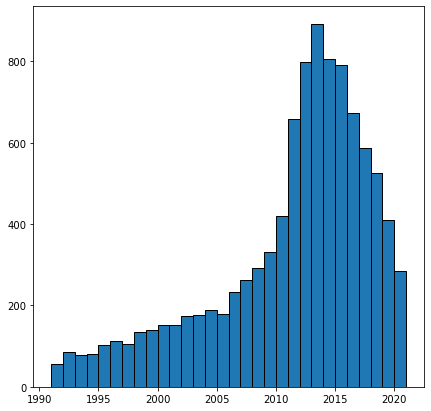

In [50]:
x = df_desc[df_desc['Year_published'] > 1990]['Year_published']
plt.figure(figsize=(7,7))
plt.hist(x=x, bins=30, edgecolor='black')
plt.show()

In [56]:
len(df_desc[df_desc['Review_number'] > 2000])

1260

In [59]:
def find_genre(entry):

    split = entry.split("'")

    genres = []

    for n in range(len(split)):
        if n%2==1:
            genres.append(split[n])

    return genres

In [60]:
df_desc['genres'] = df_desc['Genres'].map(lambda x: find_genre(x))

In [77]:
df_desc

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,genres,Age_Group
0,Obsidian,Obsidian,Jennifer L. Armentrout,English,4.17,236780,18161,Starting over sucks.When we moved to West Virg...,2011,"{'Young Adult': 3439, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/12578077-o...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Young Adult, Fantasy (Paranormal) , Fantasy, ...",Young Adult
1,Onyx,Onyx,Jennifer L. Armentrout,English,4.27,153429,10497,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,2012,"{'Young Adult': 2271, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13047090-onyx,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Young Adult, Fantasy (Paranormal) , Romance, ...",Young Adult
2,The 5th Wave,The 5th Wave,Rick Yancey,English,4.03,400600,29990,"After the 1st wave, only darkness remains. Aft...",2013,"{'Young Adult': 5436, 'Science Fiction': 3327,...",https://www.goodreads.com/book/show/16101128-t...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Young Adult, Science Fiction, Science Fiction...",Young Adult
3,The Host,The Host,Stephenie Meyer,English,3.84,915026,41673,Melanie Stryder refuses to fade away. The eart...,2008,"{'Young Adult': 4529, 'Science Fiction': 4285,...",https://www.goodreads.com/book/show/1656001.Th...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Young Adult, Science Fiction, Fantasy, Romanc...",Young Adult
4,Opal,Opal,Jennifer L. Armentrout,None,4.27,129006,9463,No one is like Daemon Black.When he set out to...,2012,"{'Young Adult': 1855, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13362536-opal,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Young Adult, Fantasy (Paranormal) , Romance, ...",Young Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11090,Always Mine,Always Mine (The Blackthorn Trilogy #1),Sophia Johnson,English,3.55,276,27,The great Lord Damron is no more than a shadow...,2006,"{'Romance (Historical Romance) ': 26, 'Science...",https://www.goodreads.com/book/show/524577.Alw...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Romance (Historical Romance) , Science Fictio...",Adult
11091,Hour of the Olympics,"Hour of the Olympics (Magic Tree House, #16)",Mary Pope Osborne,English,3.94,8710,284,The #1 bestselling chapter book series of all ...,1998,"{'Fantasy': 115, 'Childrens': 114, 'Fiction': ...",https://www.goodreads.com/book/show/181401.Hou...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Fantasy, Childrens, Fiction, Historical (Hist...",Children
11092,Tumbling Through Time,Tumbling Through Time,Gwyn Cready,English,3.34,312,51,"In her sparkling and hilarious debut, author G...",2000,"{'Romance': 28, 'Science Fiction (Time Travel)...",https://www.goodreads.com/book/show/1888734.Tu...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Romance, Science Fiction (Time Travel) , Roma...",Adult
11093,Time's Arrow,Time’s Arrow,Martin Amis,English,3.71,14934,1106,In Time's Arrow the doctor Tod T. Friendly die...,1991,"{'Fiction': 586, 'Historical (Historical Ficti...",https://www.goodreads.com/book/show/23031.Time...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Fiction, Historical (Historical Fiction) , No...",Adult


In [72]:
def age_group(x):

    if 'Children' in x:
        return 'Children'
    elif 'Family' in x:
        return 'Children'
    elif 'Kids' in x:
        return 'Children'
    elif 'Young Adult' in x:
        return 'Young Adult'
    elif 'New Adult' in x:
        return 'Young Adult'
    else:
        return 'Adult'

In [73]:
df_desc['Age_Group'] = df_desc['Genres'].map(lambda x: age_group(x))

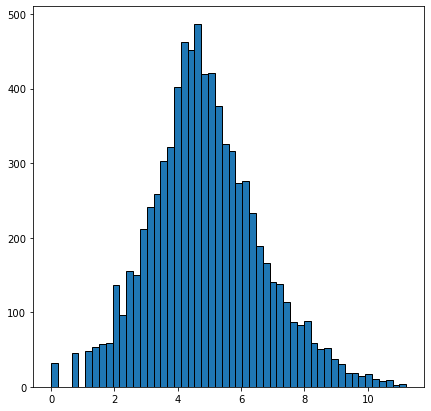

In [74]:
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Adult']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

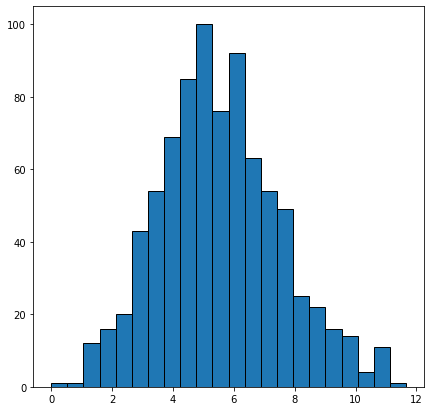

In [78]:
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Children']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

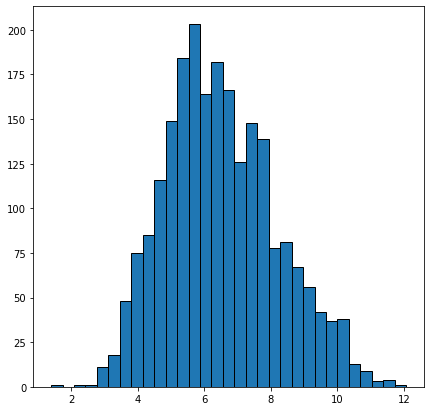

In [79]:
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Young Adult']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

In [81]:
nlp = spacy.load("en_core_web_sm")

In [84]:
spacy_1 = TextSet(X=df_desc['Book_Description'],
                  y=df_desc['Age_Group'],
                  name = 'SpaCy 1',
                  is_spacy=True, 
                  keep_stopwords=True, 
                  random_seed=42)

--- 630.1064848899841 seconds ---


In [85]:
tf_idf = TextSet(X=df_desc['Book_Description'],
                 y=df_desc['Age_Group'],
                 name='tf-idf_1',
                 is_spacy=False, 
                 keep_stopwords=False)

--- 621.1145579814911 seconds ---


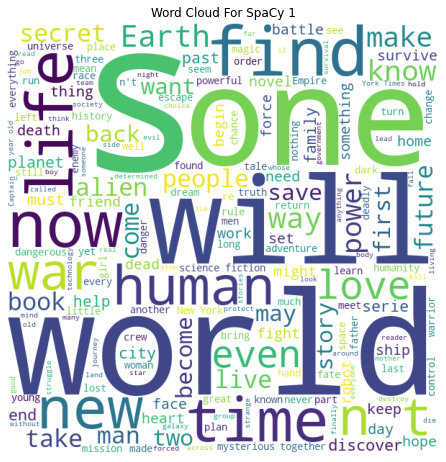

In [86]:
spacy_1.word_cloud()

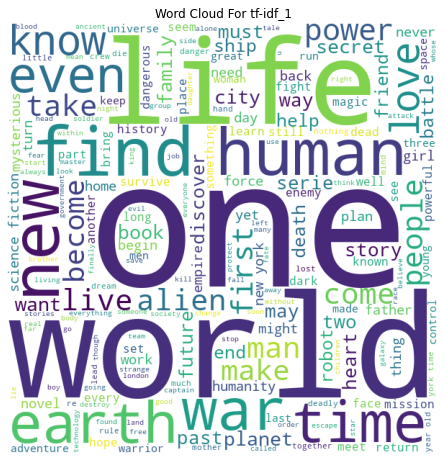

In [87]:
tf_idf.word_cloud()

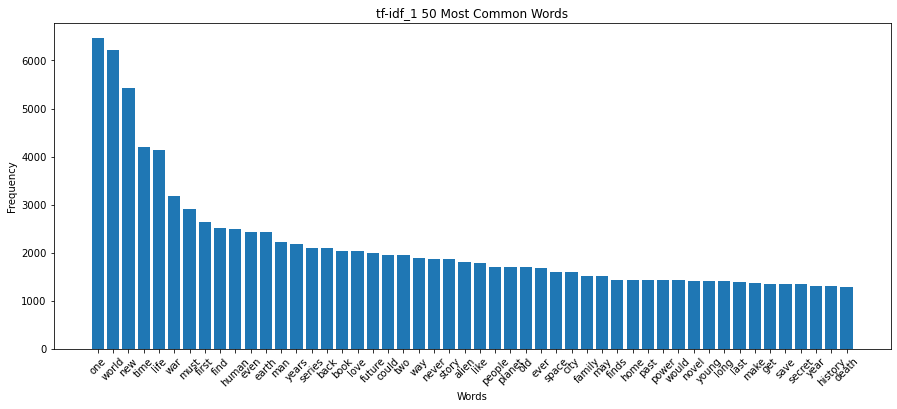

In [88]:
tf_idf.plot_frequency()

In [89]:
spacy_1.vectorize()
tf_idf.vectorize()

In [90]:
data = [spacy_1, tf_idf]

In [91]:
svm_pipe = Pipeline([('scaler', StandardScaler()), ('rbf',svm.SVC())])

grid= {
    'rbf__kernel':['rbf'],
    'rbf__gamma' :['scale','auto'],
    'rbf__C': [1, 1e12],
    'rbf__decision_function_shape': ['ovo','ovr']
}

svm_grid = GridSearchCV(svm_pipe, param_grid=grid, scoring='accuracy',cv=5)
svm_compare = ModelComparison(pipeline=svm_grid, data_list=data, y_format='label',name='svm')

In [92]:
svm_compare.fit_models()
svm_compare.score_comparison

--- 350.0309419631958 seconds to process ---


,SpaCy 1 Test,tf-idf_1 Test
Accuracy,0.722204,0.770238
Precision (Macro),0.661025,0.683722
Recall (Macro),0.358368,0.508387
F1 (Macro),0.330474,0.546932


In [93]:
svm_compare.calc_scores(data_type='holdout')
svm_compare.score_comparison

,SpaCy 1 Holdout,tf-idf_1 Holdout
Accuracy,0.731641,0.757933
Precision (Macro),0.808380,0.689567
Recall (Macro),0.371967,0.501100
F1 (Macro),0.354870,0.542767


In [94]:
df_desc['Age_Group'].value_counts(normalize=True)

Adult          0.721179
Young Adult    0.203719
Children       0.075102
Name: Age_Group, dtype: float64

In [96]:
import json

def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [97]:
keys = get_keys("/Users/amooney/.secret/nyt_api.json")
api_key = keys['api_key']
secret = keys['secret']

In [99]:
from pynytimes import NYTAPI

In [101]:
nyt = NYTAPI(api_key, parse_dates=True)

In [102]:
reviews = nyt.book_reviews(author='Stephen King')

In [107]:
df_desc['Review_number'].describe()

count     11025.000000
mean       1355.155193
std        5403.296914
min           0.000000
25%          55.000000
50%         163.000000
75%         597.000000
max      174079.000000
Name: Review_number, dtype: float64

In [109]:
df_pop = df_desc[df_desc['Review_number'] >= 55]

In [111]:
df_pop['Author_Name'].nunique()

3121

In [117]:
df_pop_r = df_pop[df_pop['Year_published'] > 2000]

In [118]:
df_list = []

for name in df_pop_r['Author_Name'].unique():
    reviews = nyt.book_reviews(author=name)
    df = pd.json_normalize(reviews)
    df_list.append(df)
    print(name, ", ", len(df))
    time.sleep(6)

review_df = pd.concat(df_list)

Jennifer L. Armentrout ,  0
Rick Yancey ,  1
Stephenie Meyer ,  1
Pittacus Lore ,  0
Melissa Landers ,  0
Ruby Dixon ,  0
Evangeline Anderson ,  0
Amie Kaufman ,  0
Marissa Meyer ,  0
Laurann Dohner ,  0
M.K. Eidem ,  0
Becky Chambers ,  0
Gena Showalter ,  0
Melissa  West ,  0
R. Lee Smith ,  0
Amanda Milo ,  0
Liu Cixin ,  0
Ilona Andrews ,  0
Eve Langlais ,  0
Sylvain Neuvel ,  0
Anna Zaires ,  0
Penelope Fletcher ,  0
S.E. Smith ,  0
Brian K. Vaughan ,  0
Nnedi Okorafor ,  0
Ernest Cline ,  1
Patrick Ness ,  1
Lyn Gala ,  0
Gini Koch ,  0
Matt Haig ,  5
Rachel Bach ,  0
R.J. Anderson ,  0
Zoey Draven ,  0
Kimberly Derting ,  0
John Scalzi ,  1
V.C. Lancaster ,  0
Lolita Lopez ,  0
Brandon Sanderson ,  1
Shaun David Hutchinson ,  0
Anna Carven ,  0
Megan Shepherd ,  0
Stacey Kade ,  0
Michelle Diener ,  0
C.L. Scholey ,  0
Poppy Rhys ,  0
Stephen King ,  66
Kiersten Fay ,  0
Lisa Henry ,  0
Eve Silver ,  0
Ann Aguirre ,  0
Alessandra Hazard ,  0
Willow Danes ,  0
Demitria Lunetta , 

Robert Silverberg ,  6
Elan Mastai ,  0
Gregory Benford ,  3
Malorie Blackman ,  0
Rod Duncan ,  0
Mark Millar ,  0
George Mann ,  0
Naomi Alderman ,  1
Kenneth Oppel ,  1
Anne Lyle ,  0
Clay Griffith ,  0
Claire North ,  0
Adam Christopher ,  0
Stephen Baxter ,  0
Christopher Moore ,  4
Suzanne Collins ,  2
Curtis Sittenfeld ,  11
Annalee Newitz ,  0
Shanna Swendson ,  0
Robin LaFevers ,  1
Robert J. Sawyer ,  1
Anne Bishop ,  0
Vic James ,  0
Hannu Rajaniemi ,  0
Andrea Cremer ,  0
Sophia McDougall ,  0
Newt Gingrich ,  4
Félix J. Palma ,  0
Jessica Spotswood ,  0
Christopher Priest ,  1
Jon Courtenay Grimwood ,  0
Owen Sheers ,  0
Dan Vyleta ,  2
Charles Stross ,  1
Garth Nix ,  0
Roshani Chokshi ,  0
Omar El Akkad ,  1
Colin Taber ,  0
Guy Saville ,  0
Jonathan Hickman ,  0
Ben Elton ,  1
David Kowalski ,  0
Ian McEwan ,  16
Tara Sim ,  0
Sydney Padua ,  1
S.E. Grove ,  0
Haruki Murakami ,  20
Lavie Tidhar ,  1
Madeleine E. Robins ,  1
Alan Moore ,  2
Beth Cato ,  0
Pip Ballantine 

Maculategiraffe ,  0
Stacia Kane ,  0
Michelle Lovric ,  0
Peter V. Brett ,  0
Patrick Rothfuss ,  0
Cecelia Ahern ,  0
Hailey Turner ,  0
Taran Matharu ,  0
Marina Vivancos ,  0
Sara B. Larson ,  0
Ariana Nash ,  0
K.D.  Edwards ,  0
Pirateaba ,  0
Kathleen A. Flynn ,  0
Megan Derr ,  0
Cari Z. ,  0
Jessica Brody ,  0
R. Cooper ,  0
Meagan Spooner ,  0
Maggie Stiefvater ,  2
Laura Thalassa ,  0
Tricia Kristufek ,  0
Sabaa Tahir ,  1
Sarah Beth Durst ,  0
Amy Harmon ,  0
Penelope Peters ,  0
Erica O'Rourke ,  0
Eressë ,  0
Revella Hawthorne ,  0
Audrey Niffenegger ,  0
Jason Latour ,  0
Cordelia Kingsbridge ,  0
Amanda   Richardson ,  0
Amy McCulloch ,  0
Melissa Grey ,  0
Janet B.  Taylor ,  0
Laurell K. Hamilton ,  0
Cristin Terrill ,  0
Moriah McStay ,  0
R.C. Lewis ,  0
Hajime Isayama ,  0
Erin Claiborne ,  0
Cooper Davis ,  0
Michelle Hodkin ,  0
Manna Francis ,  0
Pamela Palmer ,  0
Larissa Ione ,  0
Christopher G. Nuttall ,  0
Scott  Meyer ,  0
S.L. Armstrong ,  0
Daniel Price ,

Michael Farris Smith ,  1
D.A. Wearmouth ,  0
John S.  Wilson ,  0
David Estes ,  0
John       O'Brien ,  0
Gregg Rosenblum ,  0
Ben Marcus ,  4
Jessica Meigs ,  0
Mari Mancusi ,  0
T.W. Brown ,  0
Bonnie Dee ,  0
Iain McKinnon ,  0
Carla Buckley ,  0
Conrad Williams ,  0
Carole Stivers ,  0
Lydia Millet ,  11
Joshua Gayou ,  0
Zach Bohannon ,  0
Angela  Scott ,  0
Chuck Grossart ,  0
Wilson Harp ,  0
Kate  Morris ,  0
K.R. Griffiths ,  0
Claire C. Riley ,  0
Amelia C. Gormley ,  0
E.E. Borton ,  0
Rachel Higginson ,  0
Em Garner ,  0
Paige Weaver ,  0
Linda Andrews ,  0
S.M. McEachern ,  0
Andrew J.  Morgan ,  0
Pam Godwin ,  0
Stephanie Erickson ,  0
Yahtzee Croshaw ,  0
Kristen Middleton ,  0
John Varley ,  0
Elsie Chapman ,  0
Tiffany Truitt ,  0
Meghan Ciana Doidge ,  0
Lisa M. Stasse ,  0
Annie Oldham ,  0
James Harden ,  0
Dayna Lorentz ,  1
Roger Ma ,  0
David Dalglish ,  0
L.K. Rigel ,  0
E.E. Knight ,  0
Janni Lee Simner ,  0
David  Arnold ,  0
Charlotte McConaghy ,  0
Bobby 

Lauren Nicolle Taylor ,  0
Krista McGee ,  0
Shannon Stoker ,  0
Glenn Beck ,  0
Sarah Dalton ,  0
A.G. Henley ,  0
Kayla Olson ,  0
Michael Buckley ,  0
Saci Lloyd ,  0
Ruth  Silver ,  0
Karen Hesse ,  1
Stephanie  Diaz ,  0
Lesley Hauge ,  0
Mohsin Hamid ,  5
David Patneaude ,  0
Lionel Shriver ,  11
Michel Houellebecq ,  8
Lori M. Lee ,  0
David Baldacci ,  0
Michelle Rowen ,  0
Angie Smibert ,  0
Pete Hautman ,  3
Ben  Oliver ,  0
Tania Unsworth ,  0
Sarah Harian ,  0
Rachelle Dekker ,  0
Basma Abdel Aziz ,  0
Lee Strauss ,  0
Axie Oh ,  0
Jenny Moyer ,  0
Lana Krumwiede ,  0
Antony John ,  0
A.S. King ,  0
Chris   Howard ,  0
Paul  Hoffman ,  0
Jeanette Winterson ,  16
Lilliam Rivera ,  0
Janelle Stalder ,  0
Kristen Landon ,  0
Rachel Heng ,  0
Ryan Winfield ,  0
Vanessa Veselka ,  0
Gretchen McNeil ,  0
Laura van den Berg ,  3
Monica Byrne ,  0
Kate A. Boorman ,  0
Quil Carter ,  0
Joseph Bruchac ,  0
Rebecca Gober ,  0
C.J. Hill ,  0
Ted Dekker ,  0
Cale Dietrich ,  0
Jen Minkm

Jason Aaron ,  0
S.  Harrison ,  0
Samuel Peralta ,  0
Lincoln Child ,  0
Andreas Eschbach ,  0
Jay Hosler ,  0
Marshall Brain ,  0
Ben Clanton ,  0
Eric Shanower ,  0
Rachel Searles ,  0
Clive Cussler ,  2
Fiona Smyth ,  0
Gareth Roberts ,  0
Yoshiyuki Sadamoto ,  0
Keith Giffen ,  0
Scott Tipton ,  0
Richard Kadrey ,  0
Scott Hutchins ,  1
Hiromu Arakawa ,  0
Derek Benz ,  0
Karen Sandler ,  0
The Harvard Lampoon ,  0
Catherine Asaro ,  1
Somaiya Daud ,  0
London Shah ,  0
Eiichi Shimizu ,  0
James Tynion IV ,  0
Rebecca Coffindaffer ,  0
Jerry  Boyd ,  0
Micah Dean Hicks ,  0
Chris Colfer ,  1
Edward Ross ,  0
Albert Uderzo ,  0
Tom    Taylor ,  0
Simon Spurrier ,  0
Jessie Mihalik ,  0
K.B. Wagers ,  0
Sharon Lee ,  0
Valerie Valdes ,  0
Michael Cobley ,  0
James Luceno ,  0
Christopher Ruocchio ,  0
Jacqueline Koyanagi ,  0
Mike Brooks ,  0
John Jackson Miller ,  0
Linden A. Lewis ,  0
Carolyn Ives Gilman ,  0
Kristine Kathryn Rusch ,  0
Drew Karpyshyn ,  0
Lina Rather ,  0
Sarah 

Ceci Giltenan ,  0
Scott Wilbanks ,  0
Melissa E. Hurst ,  0
Thomas Mullen ,  2
Ichigo Takano ,  0
Kinley MacGregor ,  0
Carey Corp ,  0
Maddy Barone ,  0
Linda Howard ,  0
Jerry Merritt ,  0
Christine Riccio ,  0
Polly Shulman ,  0
Michael Swanwick ,  0
Kamery Solomon ,  0
J.L. Merrow ,  0
Carl Ashmore ,  0
Heather Davis ,  0
Monica Burns ,  0
Tracy Cooper-Posey ,  0
Laura Vosika ,  0
Guillaume Prévost ,  0
Claudia Lefeve ,  0
K.M. Shea ,  0
Chuck Palahniuk ,  13
Sandy Blair ,  0
Ross Welford ,  0
Donna Grant ,  0
Richard Doetsch ,  0
Alex Flinn ,  0
Charles Dickinson ,  6
Jill Myles ,  0
Bess McBride ,  0
Tamara Gill ,  0
Irina Shapiro ,  0
Courtney Cole ,  0
Pamela Mingle ,  0
Annie Barrows ,  0
Elizabeth O'Roark ,  0
John Wray ,  4
Lexa Hillyer ,  0
Laurie Brown ,  0
Lindsay  Smith ,  0
Kiese Laymon ,  2
Jennifer Connors ,  0
Lisa Cach ,  0
Chelsea Bobulski ,  0
Amanda Gray ,  0
Kara Connolly ,  0
L.E. DeLano ,  0
Jenn LeBlanc ,  0
Denise Daye ,  0
Emma Prince ,  0
Sean Ferrell ,  

In [120]:
review_df.to_csv('NYT.csv')

In [121]:
df = pd.read_csv('NYT.csv')

In [122]:
df

,Unnamed: 0,url,publication_dt,byline,book_title,book_author,summary,uuid,uri,isbn13
0,0,http://www.nytimes.com/2013/05/12/books/review...,2013-05-12,JUSTIN CRONIN,5th Wave,Rick Yancey,"In this Y.A. novel, aliens land on earth and t...",00000000-0000-0000-0000-000000000000,nyt://book/00000000-0000-0000-0000-000000000000,"['9780142425831', '9780147519085', '9780399162..."
1,0,http://www.nytimes.com/2007/08/12/books/review...,2007-08-12,LIESL SCHILLINGER,Eclipse,Stephenie Meyer,Stephenie Meyer teases her readers with the ro...,00000000-0000-0000-0000-000000000000,nyt://book/00000000-0000-0000-0000-000000000000,['9780316087360']
2,0,http://www.nytimes.com/2011/08/15/books/ready-...,2011-08-15,JANET MASLIN,Ready Player One,Ernest Cline,Ernest Cline’s novel “Ready Player One” imagin...,00000000-0000-0000-0000-000000000000,nyt://book/00000000-0000-0000-0000-000000000000,"['9780307887436', '9780307887443', '9780307887..."
3,0,http://www.nytimes.com/2011/10/16/books/review...,2011-10-16,JESSICA BRUDER,A Monster Calls,Patrick Ness,This monster forces a boy to confront his desp...,00000000-0000-0000-0000-000000000000,nyt://book/00000000-0000-0000-0000-000000000000,['9780763660659']
4,0,http://www.nytimes.com/2009/04/26/books/review...,2009-04-26,VICTORIA REDEL,The Possession of Mr. Cave,Matt Haig,"After his son’s death, the widower protagonist...",00000000-0000-0000-0000-000000000000,nyt://book/00000000-0000-0000-0000-000000000000,['9780143117308']
...,...,...,...,...,...,...,...,...,...,...
1277,8,http://www.nytimes.com/2003/01/19/books/not-a-...,2003-01-19,ANDREW O'HEHIR,Forever: A Novel,Pete Hamill,NaN,00000000-0000-0000-0000-000000000000,nyt://book/00000000-0000-0000-0000-000000000000,['9780316341110']
1278,9,http://www.nytimes.com/2004/12/22/books/22grim...,2004-12-22,WILLIAM GRIMES,Downtown: My Manhattan,Pete Hamill,NaN,00000000-0000-0000-0000-000000000000,nyt://book/00000000-0000-0000-0000-000000000000,['9780316734516']
1279,10,http://www.nytimes.com/2011/05/22/books/review...,2011-05-01,SAM ROBERTS,Tabloid City: A Novel,Pete Hamill,Books about the integration of Major League Ba...,00000000-0000-0000-0000-000000000000,nyt://book/00000000-0000-0000-0000-000000000000,['9780316020756']
1280,0,http://www.nytimes.com/2013/02/10/books/review...,2013-02-10,EOIN COLFER,Midwinterblood,Marcus Sedgwick,"In this young adult novel, characters encounte...",00000000-0000-0000-0000-000000000000,nyt://book/00000000-0000-0000-0000-000000000000,['9781250040077']
